In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dadi
import dadi.Godambe

If you use the Godambe methods in your published research, please cite Coffman et al. (2016) in addition to the main dadi paper Gutenkunst et al. (2009).
AJ Coffman, P Hsieh, S Gravel, RN Gutenkunst "Computationally efficient composite likelihood statistics for demographic inference" Molecular Biology and Evolution 33:591-593 (2016)


In [2]:
def prior_onegrow_mig(params, ns, pts):
    """
    Model with growth, split, bottleneck in pop2, exp recovery, migration

    params list is
    nu1F: The ancestral population size after growth. (Its initial size is
          defined to be 1.)
    nu2B: The bottleneck size for pop2
    nu2F: The final size for pop2
    m: The scaled migration rate
    Tp: The scaled time between ancestral population growth and the split.
    T: The time between the split and present

    ns = (n1,n2): Size of fs to generate.
    pts: Number of points to use in grid for evaluation.
    """
    nu1F, nu2B, nu2F, m, Tp, T = params
    n1,n2 = ns
    # Define the grid we'll use
    xx = yy = dadi.Numerics.default_grid(pts)

    # phi for the equilibrium ancestral population
    phi = dadi.PhiManip.phi_1D(xx)
    # Now do the population growth event.
    phi = dadi.Integration.one_pop(phi, xx, Tp, nu=nu1F)

    # The divergence
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    # We need to define a function to describe the non-constant population 2
    # size. lambda is a convenient way to do so.
    nu2_func = lambda t: nu2B*(nu2F/nu2B)**(t/T)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1=nu1F, nu2=nu2_func, 
                                    m12=m, m21=m)

    # Finally, calculate the spectrum.
    sfs = dadi.Spectrum.from_phi(phi, (n1,n2), (xx,yy))
    return sfs

In [3]:
# Load the data
data = dadi.Spectrum.from_file('YRI_CEU.fs')
ns = data.sample_sizes
# These are the grid point settings will use for extrapolation.
pts_l = [40,50,60]
# The Demographics1D and Demographics2D modules contain a few simple models,
# mostly as examples. We could use one of those.
func = prior_onegrow_mig
# Now let's optimize parameters for this model.

# The upper_bound and lower_bound lists are for use in optimization.
# Occasionally the optimizer will try wacky parameter values. We in particular
# want to exclude values with very long times, very small population sizes, or
# very high migration rates, as they will take a long time to evaluate.
# Parameters are: (nu1F, nu2B, nu2F, m, Tp, T)
upper_bound = [100, 100, 100, 10, 3, 3]
lower_bound = [1e-2, 1e-2, 1e-2, 0, 0, 0]

# This is our initial guess for the parameters, which is somewhat arbitrary.
p0 = [2,0.1,2,1,0.2,0.2]
# Make the extrapolating version of our demographic model function.
func_ex = dadi.Numerics.make_extrap_log_func(func)

# Perturb our parameters before optimization. This does so by taking each
# parameter a up to a factor of two up or down.
p0 = dadi.Misc.perturb_params(p0, fold=1, upper_bound=upper_bound,
                              lower_bound=lower_bound)
# Do the optimization. By default we assume that theta is a free parameter,
# since it's trivial to find given the other parameters. If you want to fix
# theta, add a multinom=False to the call.
# The maxiter argument restricts how long the optimizer will run. For real 
# runs, you will want to set this value higher (at least 10), to encourage
# better convergence. You will also want to run optimization several times
# using multiple sets of intial parameters, to be confident you've actually
# found the true maximum likelihood parameters.
print('Beginning optimization ************************************************')
popt = dadi.Inference.optimize_log(p0, data, func_ex, pts_l, 
                                   lower_bound=lower_bound,
                                   upper_bound=upper_bound,
                                   verbose=len(p0), maxiter=3)
# The verbose argument controls how often progress of the optimizer should be
# printed. It's useful to keep track of optimization process.
print('Finshed optimization **************************************************')

# These are the actual best-fit model parameters, which we found through
# longer optimizations and confirmed by running multiple optimizations.
# We'll work with them through the rest of this script.
# popt = [1.880, 0.0724, 1.764, 0.930, 0.363, 0.112]
# print('Best-fit parameters: {0}'.format(popt))

Beginning optimization ************************************************
6       , -1360.75    , array([ 1.213      ,  0.0673649  ,  2.17159    ,  1.70097    ,  0.328079   ,  0.117109   ])
12      , -1575.95    , array([ 2.09675    ,  0.0417644  ,  1.55108    ,  0.927637   ,  0.327263   ,  0.12955    ])
18      , -1136.75    , array([ 1.52398    ,  0.0551656  ,  1.88727    ,  1.32096    ,  0.327547   ,  0.122145   ])
24      , -1137.02    , array([ 1.52398    ,  0.0551656  ,  1.88727    ,  1.32096    ,  0.327547   ,  0.122267   ])
30      , -1670.03    , array([ 3.50938    ,  0.0742808  ,  1.6887     ,  1.03314    ,  0.332297   ,  0.0674623  ])
36      , -1082.03    , array([ 1.85196    ,  0.0591965  ,  1.83887    ,  1.24694    ,  0.328651   ,  0.106323   ])
42      , -1427.1     , array([ 1.32471    ,  0.105603   ,  1.74795    ,  0.479369   ,  0.341348   ,  0.0811008  ])
48      , -1425.93    , array([ 1.32471    ,  0.105603   ,  1.74795    ,  0.479369   ,  0.341348   ,  0.081182   ])


In [4]:
# Calculate the best-fit model AFS.
model = func_ex(popt, ns, pts_l)
# Likelihood of the data given the model AFS.
ll_model = dadi.Inference.ll_multinom(model, data)
print('Maximum log composite likelihood: {0}'.format(ll_model))
# The optimal value of theta given the model.
theta = dadi.Inference.optimal_sfs_scaling(model, data)
print('Optimal value of theta: {0}'.format(theta))

Maximum log composite likelihood: -1075.2712245212538
Optimal value of theta: 2854.6209693771025


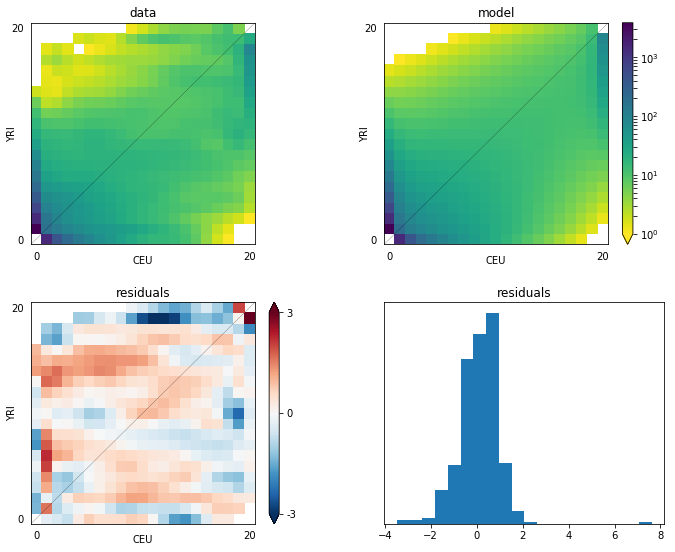

In [5]:
plt.figure(figsize=(10,8))
dadi.Plotting.plot_2d_comp_multinom(model, data, vmin=1, resid_range=3,
                                    pop_ids =('YRI','CEU'), show=False)